# Demand model: 10 min deviation


## Get packages and data

In [72]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.ndimage import gaussian_filter1d
import sys
sys.path.append('..')
from mtfunc.helper import *
# import sys
# sys.path.insert(0,'..')
# from mtfunc.helper import *
# from mtfunc.wingen import WindowGenerator

mpl.rcParams['figure.figsize'] = (20, 5)
mpl.rcParams['axes.grid'] = True
hour=60
day=24*hour
dt=10

rdata0=pd.read_csv("/Users/adrianpaeckelripoll/nest_data_tot_4.csv")
rdata0.timestamp=pd.to_datetime(rdata0.timestamp,unit='ns')
rdata0.set_index('timestamp',inplace=True)
rdata0=rdata0.resample(f'{dt}T').mean().interpolate().dropna()
rdata=rdata0
rdata=rdata.loc[:,~rdata.columns.duplicated()]
rdata.rename(columns={'global_radiation_fc':'sun_fc'},inplace=True)

## Data preprocess

In [91]:
#Function for finding the power baseline based on scipy.signal.argrelmin 
def baseline_fun(data):
    #Mimimum search comparison scope
    order=12*hour/dt
    base_idx=signal.argrelmin(data.values,order=int(order))[0]
    mask=np.empty_like(data.values)
    mask[:]=np.nan
    bs=pd.Series(mask)
    bs.iloc[base_idx]=data.iloc[base_idx]
    bs=bs.ffill()
    bs=bs.bfill()
    return bs.mean()
#Prediciton horizon
STEPS=day//dt
#Crop data
data=rdata[pd.Timestamp('2020-01-27'):pd.Timestamp('2022-01-25')].copy()
#Set PV systems
pv_signals=['power_pv_sfw_t100', 'power_pv_sfw_t101','power_pv_sfw_t102',
           'power_pv_sol_t100',
            'power_pv_meter_dfab','power_pv_move','power_pv_move_t100']
#Set load of exprimental units
loads=['power_sfw', 'power_dfab', 'power_sol','power_vw','power_umr','power_m2c','power_move']
data['power_pv']=data[pv_signals].sum(axis=1)
data['power_load']=data[loads].sum(axis=1)
#Calcualte demand power from energy balance
data['power_demand']=data.power_load-data.power_pv
# Remove outliers, demand is positive
data.loc[data.power_demand.values<0,'power_demand']=0
#Calculate 10min deviation from 60min average
data['power_dev']=data.power_load.resample('60T').mean().resample('10T').mean().interpolate()-data.power_load
#Signals to apply Gaussian filtering
signals=['power_demand','outside_temperature','wind_speed','rh_outside']
data[signals]=data[signals].apply(gaussian_filter1d,sigma=2,raw=True)
#Periodic time input starts on Monday
shft=data.reset_index()[data.index.strftime('%A')=='Monday'].index[0]
print('Cos/sin week start on: ',data.index[shft].strftime('%A'),shft)
data=data.reset_index(drop=False)
data['time']=data.index*dt-shft*dt
data['day_sin']=np.sin(2*np.pi*data.time/day)
data['day_cos']=np.cos(2*np.pi*data.time/day)
data['week_sin']=np.sin(2*np.pi*data.time/day/7)
data['week_cos']=np.cos(2*np.pi*data.time/day/7)
data['year_sin']=np.sin(2*np.pi*data.time/day/365)
data['year_cos']=np.cos(2*np.pi*data.time/day/365)
data['days']=data.time.values//(24*hour)
#Set train,validation and test data set
data.loc[:len(data)//4*3,'set']='train'
data.loc[len(data)//4*3:len(data)//11*12,'set']='validation'
data.loc[len(data)//12*11:,'set']='test'
data=data.reset_index(drop=True)
#Calcualte power baseline
for i in tqdm(range(len(data)-STEPS)):
    data.loc[i+STEPS,'bs']=baseline_fun(data.power_demand.iloc[i:i+STEPS])
data.bs=data.bs.bfill()
#Substract power baseline from demand mmnt
data['power_demand']=data.power_demand-data.bs
data.loc[data.power_demand<=0,'power_demand']=0
data.loc[:,'power_demand']=data.loc[:,'power_demand'].shift(1*day//dt)
#Define inputs for the demand model
inputs=['power_demand',
        'day_sin','day_cos','week_sin','week_cos']
#Define outputs of model
outputs=['power_dev']

data=data[outputs+inputs+['set']]
data=data.dropna()
data=data.loc[:,~data.columns.duplicated()]
#Set exmpample day (for plotting purposes)
N=121
example_df=data[N*day//dt:N*day//dt+4*day//dt]
example_df=example_df.drop(columns='set')

column_indices = {name: i for i, name in enumerate(data.columns)}
train_df = data[data.set=='train'].drop(columns='set')
val_df = data[data.set=='validation'].drop(columns='set')
test_df = data[data.set=='test'].drop(columns='set')
num_features = data.shape[1]

#Calcuate mean values for normalization
train_mean = train_df.mean()
train_std = train_df.std()

Cos/sin week start on:  Monday 0


100%|██████████████████████████████████| 104833/104833 [03:33<00:00, 490.00it/s]


## Window generator and training loop

In [161]:
#Prediction horizon
STEPS=day//dt
#Max eppoch of training loop
MAX_EPOCHS = 2000
class WindowGenerator():
    


    def __init__(self, input_width, label_width, shift,
                train_df, val_df, test_df,example_df=None,label_columns=None,input_columns=None,stride=None):
        self.label_columns = label_columns
        self.input_columns=input_columns
        # Store the raw data.
        self.stride=stride
        self.train_df = train_df[self.label_columns+self.input_columns]
        self.val_df = val_df[self.label_columns+self.input_columns]
        self.test_df = test_df[self.label_columns+self.input_columns]
        self.example_df=example_df
        print(self.train_df.columns)
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
    def plot(self, model=None, plot_col='power_dev',plot_input='power_demand', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_input]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                    label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue


            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=2)
            if model is not None:
                print(inputs.shape)
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='b', label='Predictions',
                        c='#ff7f0e', s=2)
#             plt.ylim([-1,1])

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')    
        
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        if self.input_columns is not None:
            inputs = tf.stack(
                [inputs[:, :, self.column_indices[name]] for name in self.input_columns],
                axis=-1)
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])


        return inputs, labels

    def make_dataset(self, data,batch_size=32,shuffle=True):
#         print(data)
        data = np.array(data, dtype=np.float32)
#         print(data.shape)
        if self.stride is not None: st=self.stride
        else: st=1
        print(data.shape)
            
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=st,

        shuffle=shuffle,
        batch_size=batch_size,)

        ds = ds.map(self.split_window)
#         print(ds)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
#       """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, 'example_df', None)
        if result is None:
            self._example = self.train
        else: 
            self._example=self.make_dataset(self.example_df,batch_size=3,shuffle=True)
        return next(iter(self._example))
        
def compile_and_fit(model, window, patience=20):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=patience,mode='min',restore_best_weights=True)
    filepath='checkpoints/%s.{epoch:02d}-{val_loss:.2f}.h5'%model.name
    checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=filepath,mode='min')

    model.compile(loss=tf.losses.MeanAbsoluteError(),
                optimizer=tf.optimizers.Adam(0.01),
                metrics=[tf.metrics.MeanSquaredError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

stride=STEPS//4
conv_width= 4*hour//dt
wconv = WindowGenerator(input_width=STEPS+conv_width-1, label_width=STEPS, shift=0,
                      train_df=train_df,val_df=val_df,test_df=test_df,example_df=example_df,
                     label_columns=outputs,input_columns=inputs,stride=stride)

Index(['power_dev', 'power_demand', 'day_sin', 'day_cos', 'week_sin',
       'week_cos'],
      dtype='object')
Index(['power_dev', 'power_demand', 'day_sin', 'day_cos', 'week_sin',
       'week_cos'],
      dtype='object')


## Conv TD

In [160]:

conv_model_td = tf.keras.Sequential([
    tf.keras.layers.Input((wconv.input_width,len(inputs))),
    tf.keras.layers.Normalization(mean=train_mean.values, variance=np.square(train_std.values)),
    tf.keras.layers.Conv1D(filters=702,kernel_size=(conv_width,),activation='relu'),
    tf.keras.layers.Dense(units=714, activation='relu'),
    tf.keras.layers.Dense(units=1),
],name='convolution')
conv_model_td.summary()

Model: "convolution"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_18 (Normalizat (None, 167, 5)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 144, 702)          84942     
_________________________________________________________________
dense_41 (Dense)             (None, 144, 714)          501942    
_________________________________________________________________
dense_42 (Dense)             (None, 144, 1)            715       
Total params: 587,599
Trainable params: 587,599
Non-trainable params: 0
_________________________________________________________________


train_mean=train_df.mean()[1:]
train_std=train_df.std()[1:]
ip=tf.keras.layers.Input((9,))
norm=tf.keras.layers.Normalization(mean=train_mean.values, variance=np.square(train_std.values))(ip)
norm_model=tf.keras.Model(inputs=ip,outputs=norm)
print(train_df.iloc[10,1:]) 
pd.DataFrame(columns=inputs,data=norm_model(train_df.iloc[:24,1:]).numpy()).plot()

foo=pd.DataFrame(np.array([[1,2,3,4,5,6,7,8,9],[3,2,4,1,5,6,7,9,8],
         [9,8,7,6,5,4,3,2,1]]),index=['a','b','c']).transpose()

wfoo=WindowGenerator(3,3,0,train_df=foo,val_df=foo[:2],test_df=foo[-2:],label_columns='a',input_columns='b')
next(iter(wfoo.train))

##  Compile and fit

In [163]:
history = compile_and_fit(conv_model_td, wconv,50)

(78732, 6)
(17496, 6)
Epoch 1/2000
69/69 [==============================] - 7s 92ms/step - loss: 6.9238 - mean_squared_error: 194.4540 - val_loss: 7.0095 - val_mean_squared_error: 179.3732
Epoch 2/2000
69/69 [==============================] - 8s 109ms/step - loss: 6.9021 - mean_squared_error: 193.5296 - val_loss: 6.9624 - val_mean_squared_error: 179.8847
Epoch 3/2000
69/69 [==============================] - 8s 111ms/step - loss: 6.9005 - mean_squared_error: 193.4588 - val_loss: 6.9488 - val_mean_squared_error: 177.5320
Epoch 4/2000
69/69 [==============================] - 7s 105ms/step - loss: 6.8888 - mean_squared_error: 193.1484 - val_loss: 6.9308 - val_mean_squared_error: 178.3356
Epoch 5/2000
69/69 [==============================] - 7s 96ms/step - loss: 6.8868 - mean_squared_error: 192.4641 - val_loss: 6.9801 - val_mean_squared_error: 179.9169
Epoch 6/2000
69/69 [==============================] - 6s 92ms/step - loss: 6.8776 - mean_squared_error: 191.8052 - val_loss: 7.0661 - val_me

Epoch 98/2000
69/69 [==============================] - 6s 94ms/step - loss: 5.6264 - mean_squared_error: 101.7611 - val_loss: 6.4720 - val_mean_squared_error: 128.6980
Epoch 99/2000
69/69 [==============================] - 6s 91ms/step - loss: 5.6073 - mean_squared_error: 100.9704 - val_loss: 6.3749 - val_mean_squared_error: 123.3671
Epoch 100/2000
69/69 [==============================] - 6s 91ms/step - loss: 5.5917 - mean_squared_error: 100.4663 - val_loss: 6.4255 - val_mean_squared_error: 124.6518
Epoch 101/2000
69/69 [==============================] - 7s 95ms/step - loss: 5.6364 - mean_squared_error: 103.0188 - val_loss: 6.5414 - val_mean_squared_error: 135.3400
Epoch 102/2000
69/69 [==============================] - 7s 95ms/step - loss: 5.6129 - mean_squared_error: 101.5855 - val_loss: 6.6452 - val_mean_squared_error: 135.1626
Epoch 103/2000
69/69 [==============================] - 6s 91ms/step - loss: 5.6910 - mean_squared_error: 105.5449 - val_loss: 6.4350 - val_mean_squared_erro

Epoch 147/2000
69/69 [==============================] - 6s 93ms/step - loss: 5.3300 - mean_squared_error: 90.5029 - val_loss: 6.3368 - val_mean_squared_error: 126.7169
Epoch 148/2000
69/69 [==============================] - 7s 97ms/step - loss: 5.3337 - mean_squared_error: 90.3903 - val_loss: 6.4165 - val_mean_squared_error: 126.4616
Epoch 149/2000
69/69 [==============================] - 7s 95ms/step - loss: 5.3387 - mean_squared_error: 90.7387 - val_loss: 6.2764 - val_mean_squared_error: 121.3518
Epoch 150/2000
69/69 [==============================] - 7s 97ms/step - loss: 5.3154 - mean_squared_error: 89.8350 - val_loss: 6.2906 - val_mean_squared_error: 122.8583
Epoch 151/2000
69/69 [==============================] - 6s 86ms/step - loss: 5.2847 - mean_squared_error: 88.5337 - val_loss: 6.2538 - val_mean_squared_error: 121.2978
Epoch 152/2000
69/69 [==============================] - 6s 86ms/step - loss: 5.2656 - mean_squared_error: 87.9165 - val_loss: 6.3023 - val_mean_squared_error: 1

Epoch 196/2000
69/69 [==============================] - 6s 85ms/step - loss: 5.1294 - mean_squared_error: 82.6553 - val_loss: 6.2612 - val_mean_squared_error: 121.9742
Epoch 197/2000
69/69 [==============================] - 6s 89ms/step - loss: 5.1385 - mean_squared_error: 82.8415 - val_loss: 6.3669 - val_mean_squared_error: 121.5952
Epoch 198/2000
69/69 [==============================] - 6s 86ms/step - loss: 5.1774 - mean_squared_error: 84.2965 - val_loss: 6.2956 - val_mean_squared_error: 120.9904
Epoch 199/2000
69/69 [==============================] - 6s 90ms/step - loss: 5.1540 - mean_squared_error: 83.3387 - val_loss: 6.3127 - val_mean_squared_error: 121.9547
Epoch 200/2000
69/69 [==============================] - 6s 85ms/step - loss: 5.1629 - mean_squared_error: 83.4780 - val_loss: 6.3194 - val_mean_squared_error: 121.2773
Epoch 201/2000
69/69 [==============================] - 6s 86ms/step - loss: 5.2011 - mean_squared_error: 84.8891 - val_loss: 6.2732 - val_mean_squared_error: 1

Epoch 245/2000
69/69 [==============================] - 7s 95ms/step - loss: 5.0566 - mean_squared_error: 79.4824 - val_loss: 6.3724 - val_mean_squared_error: 122.0282
Epoch 246/2000
69/69 [==============================] - 7s 104ms/step - loss: 5.0533 - mean_squared_error: 79.3363 - val_loss: 6.5794 - val_mean_squared_error: 128.6521
Epoch 247/2000
69/69 [==============================] - 6s 91ms/step - loss: 5.1140 - mean_squared_error: 82.6722 - val_loss: 6.3661 - val_mean_squared_error: 122.2978
Epoch 248/2000
69/69 [==============================] - 6s 90ms/step - loss: 5.0853 - mean_squared_error: 80.1283 - val_loss: 6.2765 - val_mean_squared_error: 121.3272
Epoch 249/2000
69/69 [==============================] - 6s 88ms/step - loss: 5.1118 - mean_squared_error: 82.3656 - val_loss: 6.3599 - val_mean_squared_error: 126.4610
Epoch 250/2000
69/69 [==============================] - 6s 89ms/step - loss: 5.0913 - mean_squared_error: 81.4676 - val_loss: 6.3659 - val_mean_squared_error: 

Epoch 294/2000
69/69 [==============================] - 6s 89ms/step - loss: 5.0092 - mean_squared_error: 77.9066 - val_loss: 6.2642 - val_mean_squared_error: 122.3675
Epoch 295/2000
69/69 [==============================] - 6s 89ms/step - loss: 5.0141 - mean_squared_error: 77.8082 - val_loss: 6.2872 - val_mean_squared_error: 123.0509
Epoch 296/2000
69/69 [==============================] - 6s 89ms/step - loss: 4.9675 - mean_squared_error: 76.7533 - val_loss: 6.2095 - val_mean_squared_error: 119.7013
Epoch 297/2000
69/69 [==============================] - 6s 90ms/step - loss: 5.0170 - mean_squared_error: 77.9811 - val_loss: 6.2580 - val_mean_squared_error: 119.3245
Epoch 298/2000
69/69 [==============================] - 7s 97ms/step - loss: 5.0584 - mean_squared_error: 79.6165 - val_loss: 6.3265 - val_mean_squared_error: 120.8916
Epoch 299/2000
69/69 [==============================] - 7s 97ms/step - loss: 5.0099 - mean_squared_error: 77.6520 - val_loss: 6.2188 - val_mean_squared_error: 1

Epoch 343/2000
69/69 [==============================] - 6s 89ms/step - loss: 4.9082 - mean_squared_error: 74.1086 - val_loss: 6.2448 - val_mean_squared_error: 116.7833
Epoch 344/2000
69/69 [==============================] - 6s 92ms/step - loss: 4.9440 - mean_squared_error: 75.4389 - val_loss: 6.1342 - val_mean_squared_error: 116.0203
Epoch 345/2000
69/69 [==============================] - 6s 92ms/step - loss: 4.9410 - mean_squared_error: 75.0062 - val_loss: 6.2395 - val_mean_squared_error: 118.4869
Epoch 346/2000
69/69 [==============================] - 6s 94ms/step - loss: 4.9220 - mean_squared_error: 74.5858 - val_loss: 6.1283 - val_mean_squared_error: 116.5080
Epoch 347/2000
69/69 [==============================] - 7s 94ms/step - loss: 5.0072 - mean_squared_error: 78.9996 - val_loss: 6.3554 - val_mean_squared_error: 124.9039
Epoch 348/2000
69/69 [==============================] - 6s 88ms/step - loss: 4.9327 - mean_squared_error: 75.5441 - val_loss: 6.2230 - val_mean_squared_error: 1

Epoch 392/2000
69/69 [==============================] - 7s 100ms/step - loss: 4.8587 - mean_squared_error: 72.2703 - val_loss: 6.1459 - val_mean_squared_error: 114.7544
Epoch 393/2000
69/69 [==============================] - 7s 101ms/step - loss: 4.8705 - mean_squared_error: 72.8229 - val_loss: 6.2199 - val_mean_squared_error: 118.8032
Epoch 394/2000
69/69 [==============================] - 7s 99ms/step - loss: 4.8285 - mean_squared_error: 71.7548 - val_loss: 6.1331 - val_mean_squared_error: 115.7530
Epoch 395/2000
69/69 [==============================] - 7s 98ms/step - loss: 4.8778 - mean_squared_error: 73.2546 - val_loss: 6.2537 - val_mean_squared_error: 121.2524
Epoch 396/2000
69/69 [==============================] - 8s 121ms/step - loss: 4.8360 - mean_squared_error: 71.8972 - val_loss: 6.1898 - val_mean_squared_error: 117.3211
Epoch 397/2000
69/69 [==============================] - 7s 105ms/step - loss: 4.8823 - mean_squared_error: 73.4323 - val_loss: 6.1461 - val_mean_squared_erro

Epoch 441/2000
69/69 [==============================] - 6s 88ms/step - loss: 4.8206 - mean_squared_error: 71.1759 - val_loss: 6.1477 - val_mean_squared_error: 116.9271
Epoch 442/2000
69/69 [==============================] - 8s 118ms/step - loss: 4.8197 - mean_squared_error: 71.2956 - val_loss: 6.1017 - val_mean_squared_error: 114.9189
Epoch 443/2000
69/69 [==============================] - 7s 101ms/step - loss: 4.8076 - mean_squared_error: 71.2173 - val_loss: 6.0982 - val_mean_squared_error: 114.1709
Epoch 444/2000
69/69 [==============================] - 7s 99ms/step - loss: 4.8339 - mean_squared_error: 71.7966 - val_loss: 6.0964 - val_mean_squared_error: 115.4747
Epoch 445/2000
69/69 [==============================] - 7s 102ms/step - loss: 4.7977 - mean_squared_error: 70.6192 - val_loss: 6.3016 - val_mean_squared_error: 119.1713
Epoch 446/2000
69/69 [==============================] - 7s 102ms/step - loss: 4.8024 - mean_squared_error: 70.5456 - val_loss: 6.3483 - val_mean_squared_erro

69/69 [==============================] - 8s 116ms/step - loss: 4.7542 - mean_squared_error: 69.1942 - val_loss: 6.1720 - val_mean_squared_error: 116.9326
Epoch 538/2000
69/69 [==============================] - 7s 96ms/step - loss: 4.7289 - mean_squared_error: 68.4741 - val_loss: 6.2888 - val_mean_squared_error: 118.6223
Epoch 539/2000
69/69 [==============================] - 6s 94ms/step - loss: 4.7506 - mean_squared_error: 69.0723 - val_loss: 6.3007 - val_mean_squared_error: 118.9830
Epoch 540/2000
69/69 [==============================] - 7s 96ms/step - loss: 4.7591 - mean_squared_error: 69.0680 - val_loss: 6.2387 - val_mean_squared_error: 117.9043
Epoch 541/2000
69/69 [==============================] - 7s 104ms/step - loss: 4.7348 - mean_squared_error: 68.4114 - val_loss: 6.4520 - val_mean_squared_error: 123.4623
Epoch 542/2000
69/69 [==============================] - 7s 103ms/step - loss: 4.7326 - mean_squared_error: 68.5803 - val_loss: 6.0931 - val_mean_squared_error: 113.7550
Epoc

Epoch 586/2000
69/69 [==============================] - 7s 95ms/step - loss: 4.6804 - mean_squared_error: 66.9088 - val_loss: 6.1435 - val_mean_squared_error: 115.2203
Epoch 587/2000
69/69 [==============================] - 7s 97ms/step - loss: 4.7664 - mean_squared_error: 68.8407 - val_loss: 6.3228 - val_mean_squared_error: 120.0941
Epoch 588/2000
69/69 [==============================] - 7s 98ms/step - loss: 4.7139 - mean_squared_error: 67.7935 - val_loss: 6.1358 - val_mean_squared_error: 114.3116
Epoch 589/2000
69/69 [==============================] - 7s 98ms/step - loss: 4.7971 - mean_squared_error: 70.2385 - val_loss: 6.1716 - val_mean_squared_error: 115.3624
Epoch 590/2000
69/69 [==============================] - 7s 99ms/step - loss: 4.6667 - mean_squared_error: 66.3760 - val_loss: 6.1942 - val_mean_squared_error: 117.7204
Epoch 591/2000
69/69 [==============================] - 8s 113ms/step - loss: 4.6398 - mean_squared_error: 65.9457 - val_loss: 6.1606 - val_mean_squared_error: 

In [170]:
conv_model_td.save('../saved_models/loss_10minpowerdev_convtd_powerdemand_dayweeksincos_4h.h5')

INFO:tensorflow:Assets written to: ../saved_models/loss_10minpowerdev_convtd_powerdemand_dayweeksincos_4h/assets


(17496, 6)
(3, 167, 5)
(3, 167, 5)
(3, 167, 5)


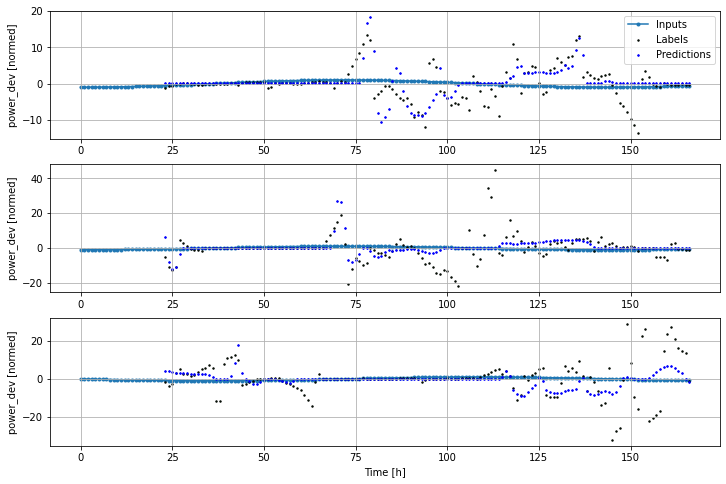

In [176]:
%matplotlib inline
wconv.example_df=val_df
wconv.plot(conv_model_td)
# wconv.plot(conv_lstm_td)

## Evaluation


In [139]:
val_performance = {}
performance = {}
val_performance['conv time-dis'] = conv_model_td.evaluate(wconv.val)
performance['conv time-dis'] = conv_model_td.evaluate(wconv.test)

IPython.display.clear_output()

In [143]:
mpl.rcParams['figure.figsize']=(20,5)
# for n in range(60):
#     train_df.iloc[24*n:24+24*n,0].plot()

x = np.arange(len(performance))
width = 0.3
metric_name = 'loss'
metric_index = dense.metrics_names.index(metric_name)
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Power demand, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()